# 4.1 Building a Simple Periodogram

In previous sections, we've looked at some real life time series and talked about using sinusoids as a good model to fit some time series variability. However, we came across a problem; we can't fit a period for the sinusoid model using our simple linear algebra. 

Let's come back to this idea and see what we can do.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
sns.set_context("talk", font_scale=0.8)

### Working with Sinusoids

We have some astrophysical intuition for this target that since this is a star, and stars rotate, a sinusoid model might be a reasonable one for this data.

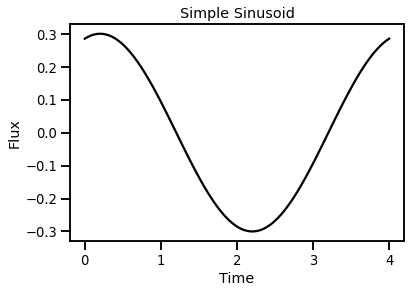

In [2]:
x = np.linspace(0, 4, 100)
period = 4
amplitude = 0.3
phase = 1.254
y = amplitude * np.sin(x * (2 * np.pi)/period + phase)
fig, ax = plt.subplots()
ax.plot(x, y, c='k')
ax.set(xlabel='Time', ylabel='Flux', title='Simple Sinusoid');

Above is the curve $sin(\frac{2x\pi}{P})$ where $P$ is the period of the curve. If we want to make a model where **$P$ is a variable** in our model, this **cannot be a linear model** because it is inside the $sin$ function. There is no way for us to tune the period $P$ in this model by multiplying by a coefficient.

Multiplying by a coefficient will only change the amplitude of the curve:

$w_0 sin(\frac{2x\pi}{P})$

So what do we do? In a case where we happen to know a period, we can use a linear model to find the best fitting amplitude of the sinusoid, but we can't use a linear model to find the best fitting period. Let's break this up, to fit a sinusoid model we're going to need to be able to fit

- The amplitude
- The period
- The phase

For **amplitude**, we can already do that, if we set up a linear model the coefficients will tune the amplitude. For the **phase**, we can rely on [trigonometric identities](https://en.wikipedia.org/wiki/List_of_trigonometric_identities#Shifts_and_periodicity) that tell us that a linear combination of sine and cosine curves with different weights produce a new sinusoid with a different phase:

$a\cos x+b\sin x=c\cos(x+\varphi)$

So, for any given period, we can make a linear model of a sine and cosine, and that will allow us to fit any amplitude and any phase. Let's try it!

In [3]:
# Design matrix that includes a sine and cosine with fixed period
A = np.vstack([np.sin(2 * np.pi * x/period),
               np.cos(2 * np.pi * x/period)]).T

In [4]:
# Fit to find best fitting weights
w = np.linalg.solve(A.T.dot(A), A.T.dot(y))

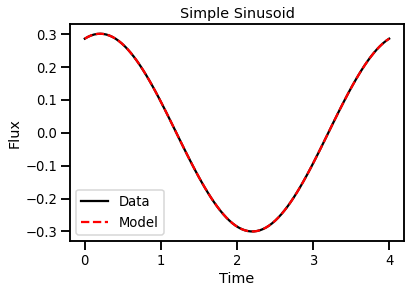

In [5]:
fig, ax = plt.subplots()
ax.plot(x, y, c='k', label='Data')
ax.plot(x, A.dot(w), c='r', ls='--', label='Model')
ax.set(xlabel='Time', ylabel='Flux', title='Simple Sinusoid')
ax.legend();

As you can see above I've created a linear model of a sine and a cosine and fit my data with the correct amplitude, and correct phase.

## Iterative over non-linear variables.

Often, I will need to find the period of some time series variability. Unfortunately, since including period makes this model non-linear, I'll have to iterate. Below I make an example where the data has a random period between 1 and 2 days, a random amplitude, and random phase.

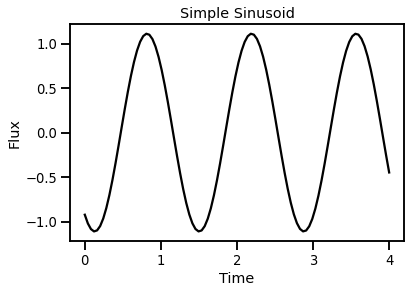

In [6]:
x = np.linspace(0, 4, 100)
period = np.random.uniform(low=1, high=2)
amplitude = np.random.normal()
phase = np.random.uniform(low=0, high=2*np.pi)
y = amplitude * np.sin(x * (2 * np.pi)/period + phase)
fig, ax = plt.subplots()
ax.plot(x, y, c='k')
ax.set(xlabel='Time', ylabel='Flux', title='Simple Sinusoid');

Let's iterate over some trial periods to find the best fitting period

<div class="admonition tip">
<p class="admonition-title">Period spacing</p>
    <p>When calculating periodograms like this, we usually have even spacing in frequency, not period.</p>
</div>

In [21]:
trial_periods = 1/np.linspace(1/10, 1/0.1, 1000)[::-1]
best_fitting_weights = np.zeros((2, trial_periods.shape[0]))
for idx, trial_period in enumerate(trial_periods):
    # Design matrix that includes a sine and cosine with fixed period
    A = np.vstack([np.sin(2 * np.pi * x/trial_period), np.cos(2 * np.pi * x/trial_period)]).T
    # Fit to find best fitting weights
    best_fitting_weights[:, idx] = np.linalg.solve(A.T.dot(A), A.T.dot(y))

In [22]:
best_fitting_weights.shape

(2, 1000)

Now we have an array of best fitting weights. The shape is 2 by 1000, because we have 2 vectors in our design matrix (sine and cosine) and we have 1000 test periods. 

We'll define the "power" of the fit for any given period as the sum of the squares of the weight coefficients, i.e. $w_{0, p}^2 + w_{1, p}^2$ for any given period $p$.

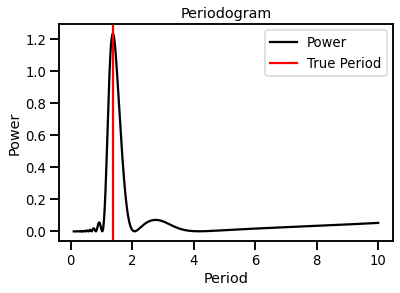

In [23]:
fig, ax = plt.subplots()
power = np.sum(best_fitting_weights**2, axis=0)
ax.plot(trial_periods, power, c='k', label='Power')
ax.axvline(period, color='r', label='True Period')
ax.legend()
ax.set(xlabel='Period', ylabel='Power', title='Periodogram');

Now we've created a simple, classical periodogram! We can see there's a clear increase in power at the correct  period. We can rebuild the model and see how well it fits the data.

In [24]:
best_fit_period = trial_periods[np.argmax(power)]
# Design matrix that includes a sine and cosine with fixed period
A = np.vstack([np.sin(2 * np.pi * x/best_fit_period), np.cos(2 * np.pi * x/best_fit_period)]).T
# Fit to find best fitting weights
w = np.linalg.solve(A.T.dot(A), A.T.dot(y))

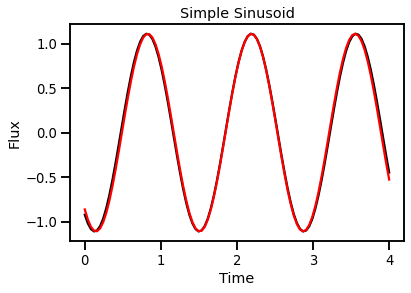

In [25]:
fig, ax = plt.subplots()
ax.plot(x, y, c='k')
ax.plot(x, A.dot(w), c='r')
ax.set(xlabel='Time', ylabel='Flux', title='Simple Sinusoid');

Looks pretty good! If we wanted to be more accurate, we would increase the number of trial periods. 

Let's try this on our Kepler dataset.

In [26]:
lc = lk.search_lightcurve('Kepler-10', 
                          mission='Kepler', 
                          quarter=10, 
                          exptime=1800).download()

Above, I've downloaded data for the target "Kepler-10", which is a famous star from the Kepler mission. This star has a planet transiting around it. The time-series data here is just the brightness of the target over time. We can grab the data out of this Python object. I will use only 1500 elements as an example.

**Note:** `lc` is a `lightkurve` object, which you might already know how to work with. For the purposes of this tutorial, I'm just going to take the time and flux components from this object and work with them as `numpy` arrays.

In [37]:
x, y = (lc.remove_nans().time.value[500:2000],
        np.asarray(lc.remove_nans().normalize().flux.value)[500:2000])
x -= x.mean()
y -= y.mean()

Here's an example of some of the elements in these arrays

In [38]:
x[:5]

array([-15.80454073, -15.7841067 , -15.76367287, -15.74323894,
       -15.72280491])

In [39]:
y[:5]

array([-6.0677528e-05, -9.2625618e-05,  1.1980534e-05, -4.6133995e-05,
       -4.1663647e-05], dtype=float32)

Now we have the array of times `x` and the array of flux values `y`. Let's plot them below.

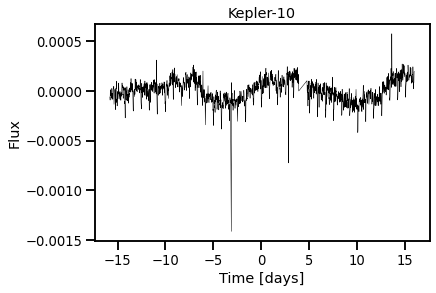

In [40]:
fig, ax = plt.subplots()
ax.plot(x, y, lw=0.5, c='k')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10');

Let's try to find the best fitting period for this time series.

In [43]:
trial_periods = 1/np.linspace(1/30, 1/5, 1000)[::-1]
best_fitting_weights = np.zeros((2, trial_periods.shape[0]))
for idx, trial_period in enumerate(trial_periods):
    # Design matrix that includes a sine and cosine with fixed period
    A = np.vstack([np.sin(2 * np.pi * x/trial_period), np.cos(2 * np.pi * x/trial_period)]).T
    # Fit to find best fitting weights
    best_fitting_weights[:, idx] = np.linalg.solve(A.T.dot(A), A.T.dot(y))

[Text(0.5, 0, 'Period'), Text(0, 0.5, 'Power'), Text(0.5, 1.0, 'Periodogram')]

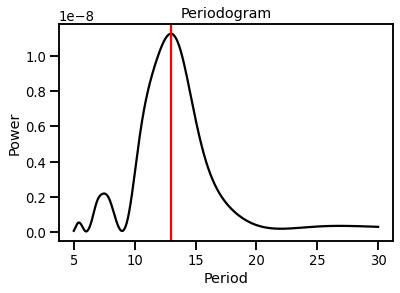

In [44]:
fig, ax = plt.subplots()
power = np.sum(best_fitting_weights[:2]**2, axis=0)
ax.plot(trial_periods, power, c='k')
ax.axvline(trial_periods[np.argmax(power)], color='r')
ax.set(xlabel='Period', ylabel='Power', title='Periodogram')

Now we can make the model at that period

In [45]:
period = trial_periods[np.argmax(power)]
A = np.vstack([np.sin(2 * np.pi * x/period), np.cos(2 * np.pi * x/period), np.ones_like(x)]).T
w = np.linalg.solve(A.T.dot(A), A.T.dot(y))

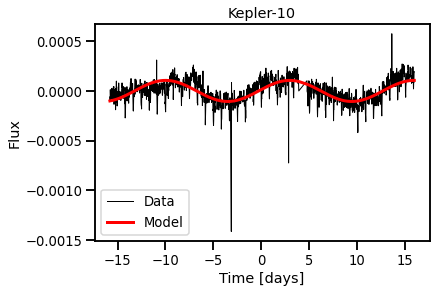

In [46]:
fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.plot(x, A.dot(w), lw=3, label='Model', c='r')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend();

Now we've iterated over period, we've found the best fit sinusoid model! We can use the periodogram above to tell us the best fit period in the data. 

In [47]:
period

12.979644867908185

## Why is this important?

You might ask why is this important. There are lots of tools to compute a periodogram which don't require you to write the design matrix, and in fact there are *better* ways of doing a periodogram. So why is this useful? Well two reasons;

1. This gives us some intuition for what a periodogram is doing
2. We can now augment this model, to allow us to fit other behavior simultaneously!

Let's imagine we have this scenario instead:

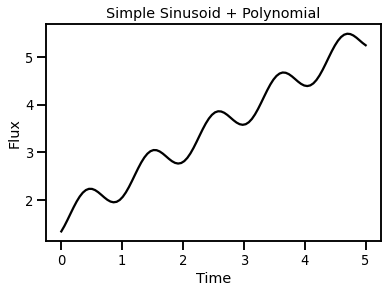

In [48]:
x = np.linspace(0, 5, 100)
period = np.random.uniform(low=1, high=2)
amplitude = np.random.normal()
phase = np.random.uniform(low=0, high=2*np.pi)
w = np.random.normal(size=2)
y = amplitude * np.sin(x * (2 * np.pi)/period + phase) + w[0]*x**0 + w[1]*x**1
fig, ax = plt.subplots()
ax.plot(x, y, c='k')
ax.set(xlabel='Time', ylabel='Flux', title='Simple Sinusoid + Polynomial');

Now, we have two parts of the model; there is an additive polynomial trend on top of our sinusoid. We can easily build a linear model to fit both of these at the same time!

Below I obtain the periodogram in the same way as above, but this time, I include polynomial terms. The design matrix is made up of the column vectors: 
- $sin(\mathbf{x})$, $cos(\mathbf{x})$ for a `polyorder` of 0, 
- $sin(\mathbf{x})$, $cos(\mathbf{x})$, $\mathbf{x}^0$ for a `polyorder` of 1, 
- $sin(\mathbf{x})$, $cos(\mathbf{x})$, $\mathbf{x}^0$, $\mathbf{x}^1$ for a `polyorder` of 2 

The true simulated data above has a polynomial order of 2.

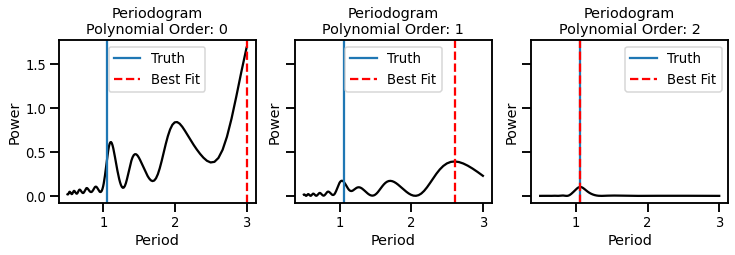

In [49]:
trial_periods = 1/np.linspace(1/3, 1/0.5, 200)[::-1]
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
for polyorder in np.arange(3):
    ax = axs[polyorder]
    best_fitting_weights = np.zeros((2+polyorder, trial_periods.shape[0]))
    for idx, trial_period in enumerate(trial_periods):
        # Design matrix that includes a sine and cosine with fixed period
        A = np.vstack([np.sin(2 * np.pi * x/trial_period),
                       np.cos(2 * np.pi * x/trial_period),
                      *[x**idx for idx in range(polyorder)]]).T
        # Fit to find best fitting weights
        best_fitting_weights[:, idx] = np.linalg.solve(A.T.dot(A), A.T.dot(y))
    power = np.sum(best_fitting_weights[:2]**2, axis=0)
    ax.plot(trial_periods, power, c='k')
    ax.axvline(period, color='C0', label='Truth')
    ax.axvline(trial_periods[np.argmax(power)], color='r', ls='--', label='Best Fit')
    ax.legend()
    ax.set(xlabel='Period', ylabel='Power', title=f'Periodogram\nPolynomial Order: {polyorder}')

You can see the period is estimated incorrectly if the correct order polynomial is not included. Let's look at the best fitting period

In [50]:
print(f'True Period: {period}')
print(f'Best Fit Period: {trial_periods[np.argmax(power)]}')

True Period: 1.0580836121681996
Best Fit Period: 1.0585106382978722


They're super close! So, the benefit of working like this is that we can easily augment the model with other components, and find the best fitting period in the presence of other signals.

<div class="admonition">
<p class="admonition-title">The Take Aways</p>
    <p> In this notebook you should have seen that <ul>
    <li>1) if your model has some variables that are non linear (in this case period) you can iterate over those variables to find the best fit </li>
    <li>2) it is possible to fit a simple periodogram to your data using sines and cosines to find the best period </li>
    <li>3) it is possible to make a model including many components, for example you can jointly fit a sinusoid model and a polynomial to your data, to model complex behavior.</li></ul></p>
</div>

<div class="admonition tip">
<p class="admonition-title">More information about periodograms</p>
    <p> This was a very shallow dive into how to make a periodogram using a linear least squares approach. If you use periodograms a lot in your science I strongly recommend you take a look at this excellent review of the periodogram which explains in much greater detail the nuances of periodograms: <a href=https://iopscience.iop.org/article/10.3847/1538-4365/aab766>Understanding the Lomb–Scargle Periodogram</a></p>
</div>